In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid") 

import sidetable as stb

from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats
from scipy.stats import kstest

from datetime import datetime, timedelta

from datetime import date
import holidays 

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')


/tmp/ipykernel_20432/2417048622.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
df = pd.read_pickle('data/bikes_limpio.pkl')
df.head(1)

,fecha,estacion,año,mes,festivo,dia_semana,laboral,clima,temperatura,sensacion_termica,humedad,viento,casual,registrado,total
0,2018-01-01,invierno,2018,enero,sí,lunes,no,niebla,14.1,18.2,80.6,10.7,331,654,985


In [3]:
numericas = df.select_dtypes(np.number)
numericas.head()

,temperatura,sensacion_termica,humedad,viento,casual,registrado,total
0,14.1,18.2,80.6,10.7,331,654,985
1,14.9,17.7,69.6,16.7,131,670,801
2,8.1,9.5,43.7,16.6,120,1229,1349
3,8.2,10.6,59.0,10.7,108,1454,1562
4,9.3,11.5,43.7,12.5,82,1518,1600


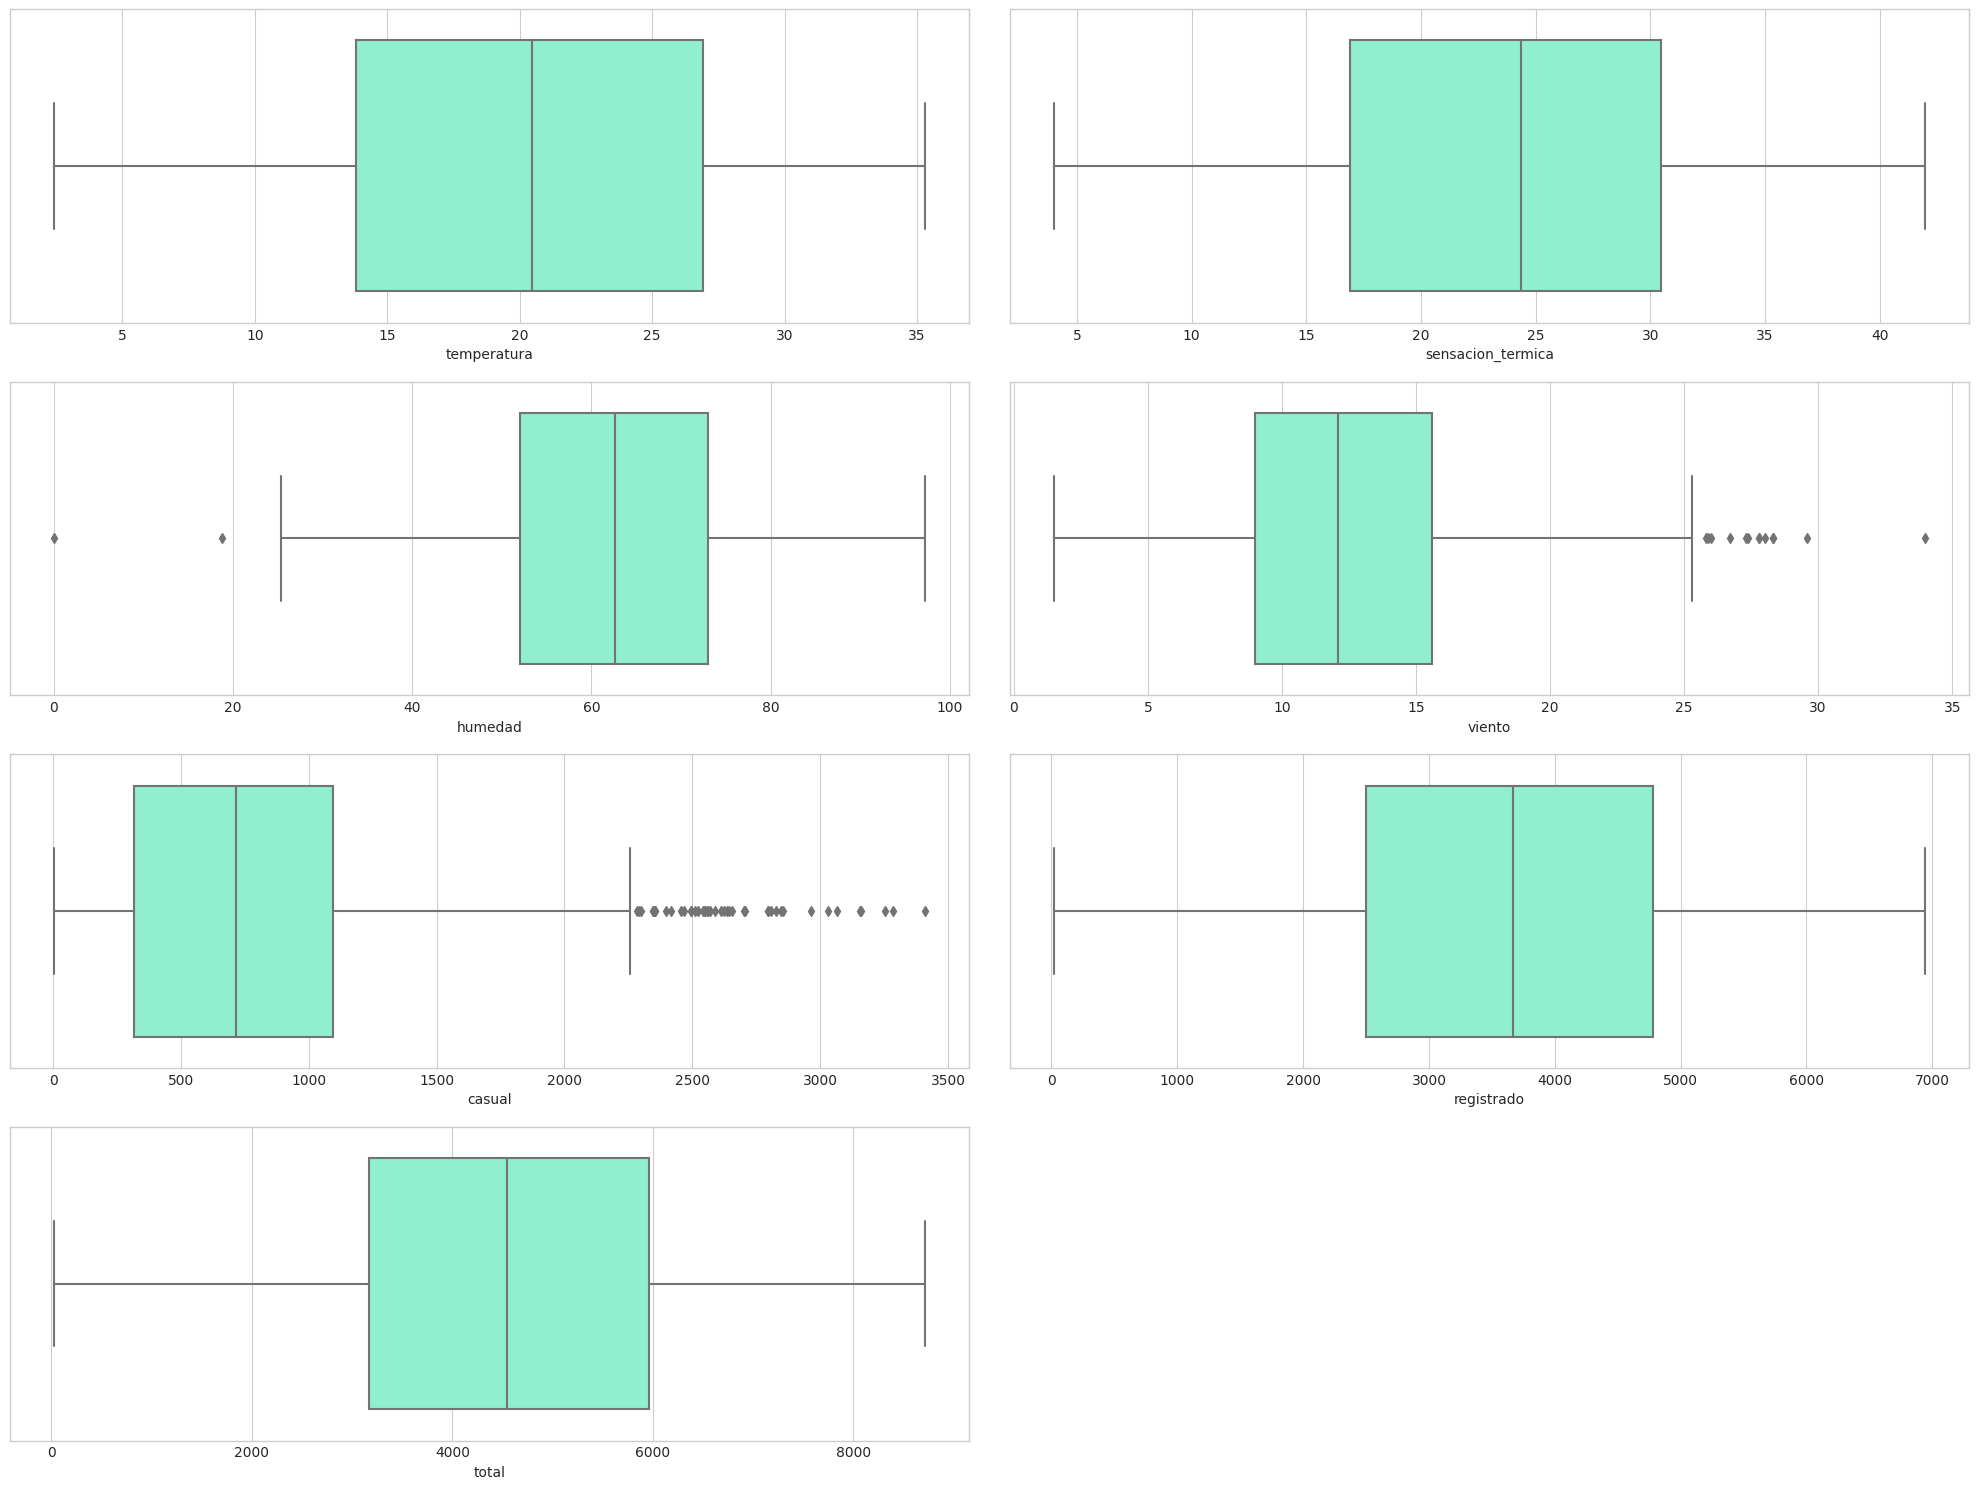

In [4]:
# Procedemos a revisar los outliers de las variables numericas de nuestro df.

fig, axes = plt.subplots(4, 2, figsize=(20,15))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
        sns.boxplot(x = numericas[columna],
            data = df, ax=axes[indice], 
            color = "aquamarine"); 
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

Hemos visualizado que varias de nuestras variables si continen outliers. Son especialmente destacables, 'Viento' y 'Casual'. También hay outliers en humedad y tendremos que revisarlos en profundidad más adelante, ya que washington dc destaca por su clima húmedo.

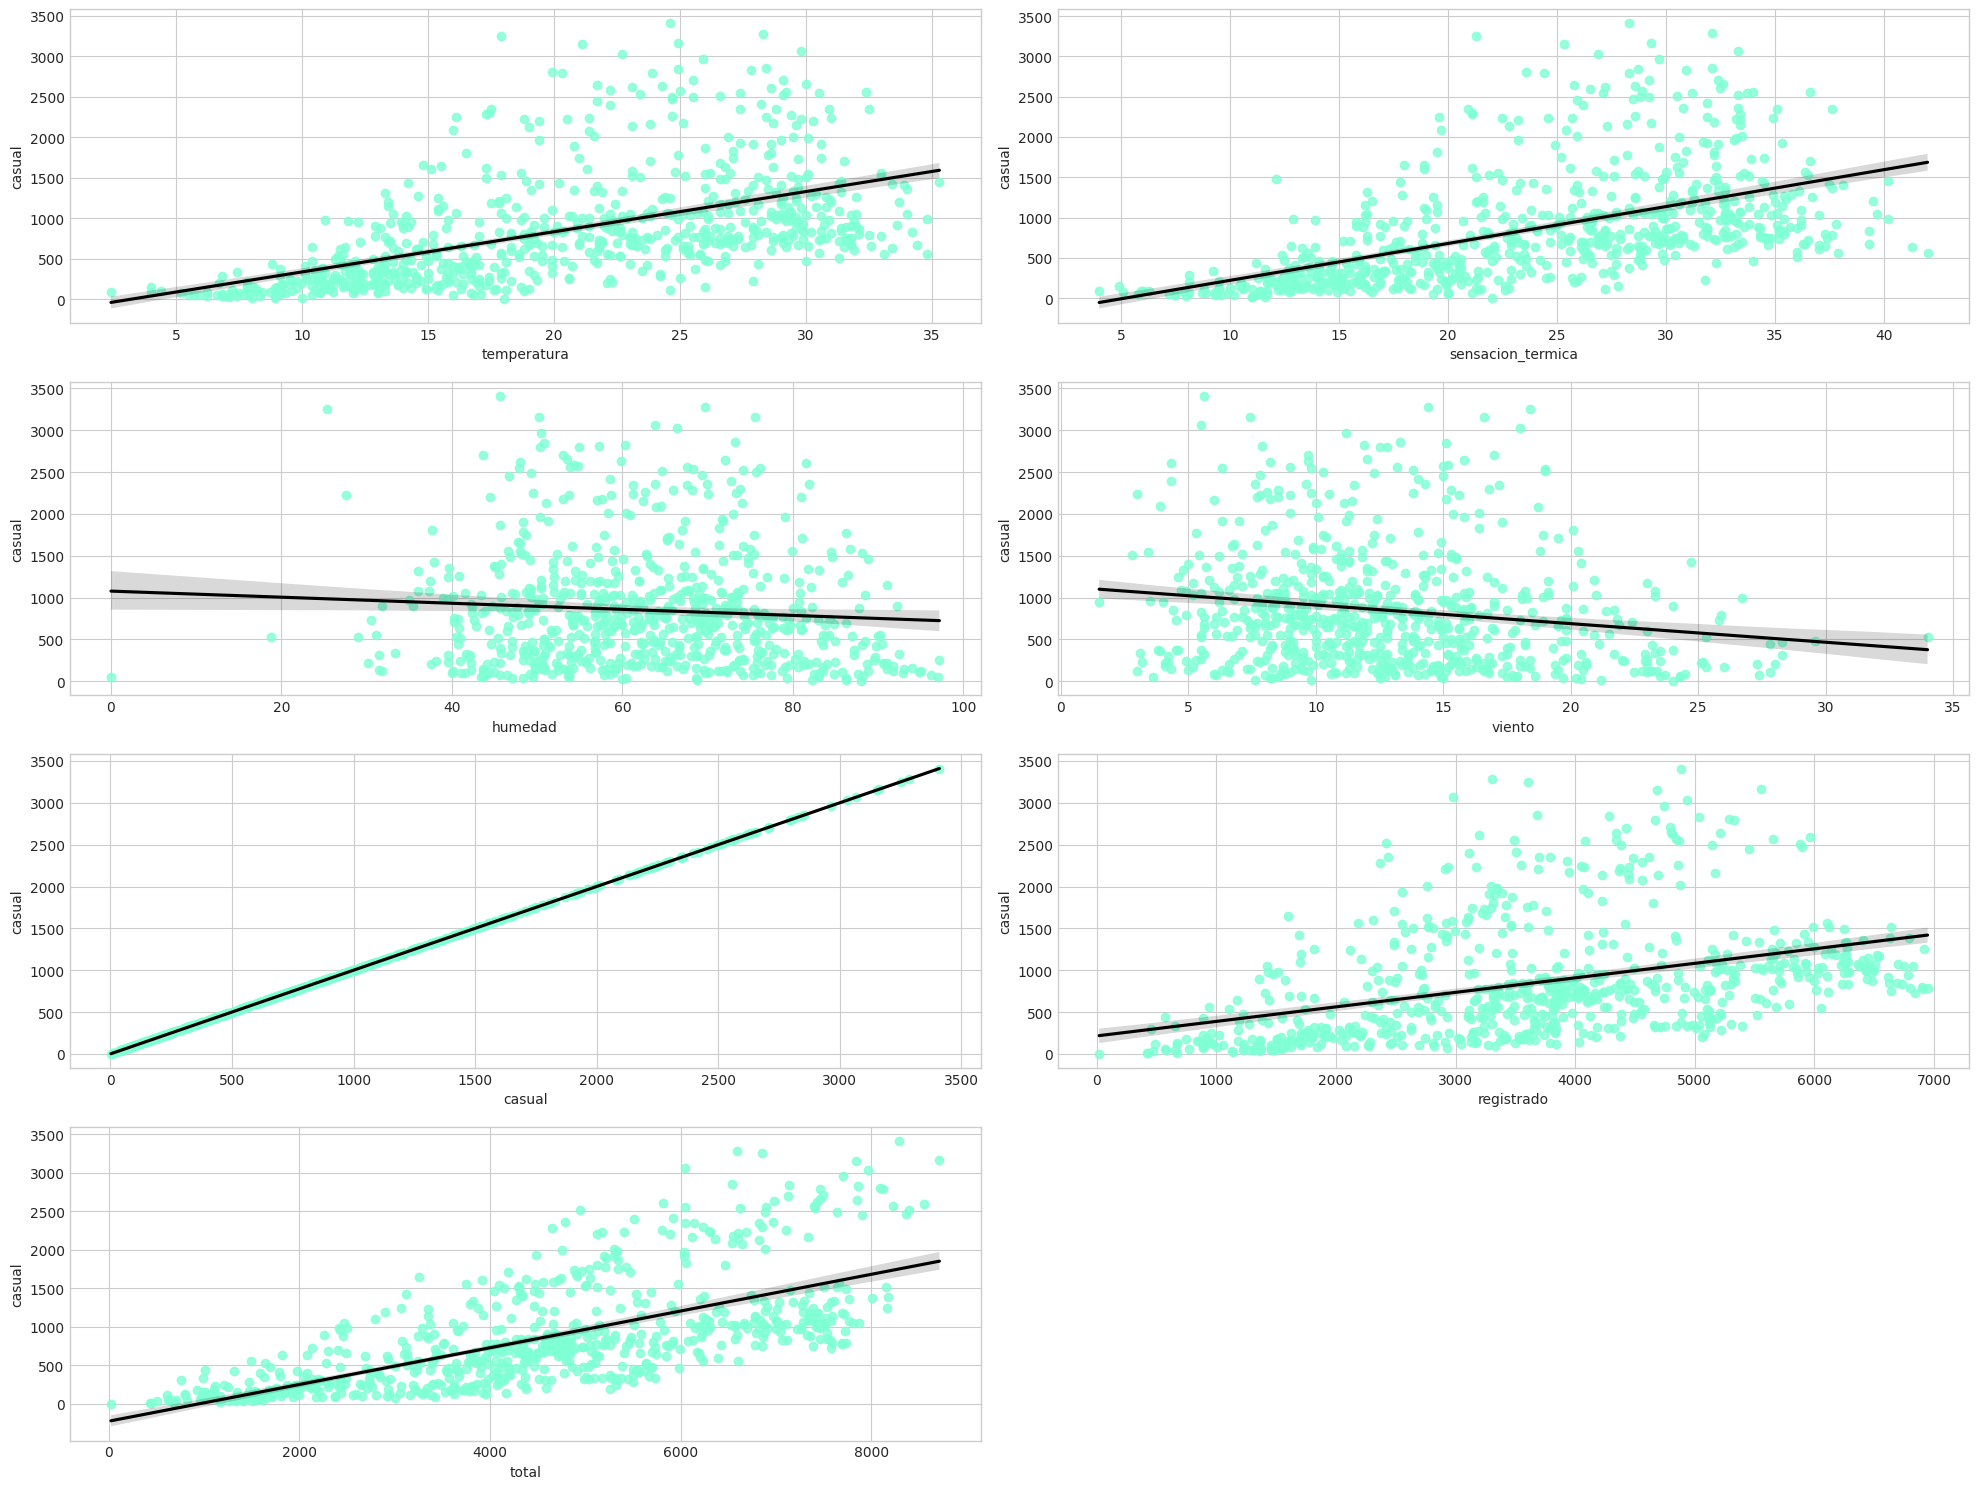

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(20,15))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
        sns.regplot(x = numericas[columna],
                        y = "casual",
                        data = numericas, ax=axes[indice], 
                        color = "aquamarine", line_kws= {"color": "black"}); 
        
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

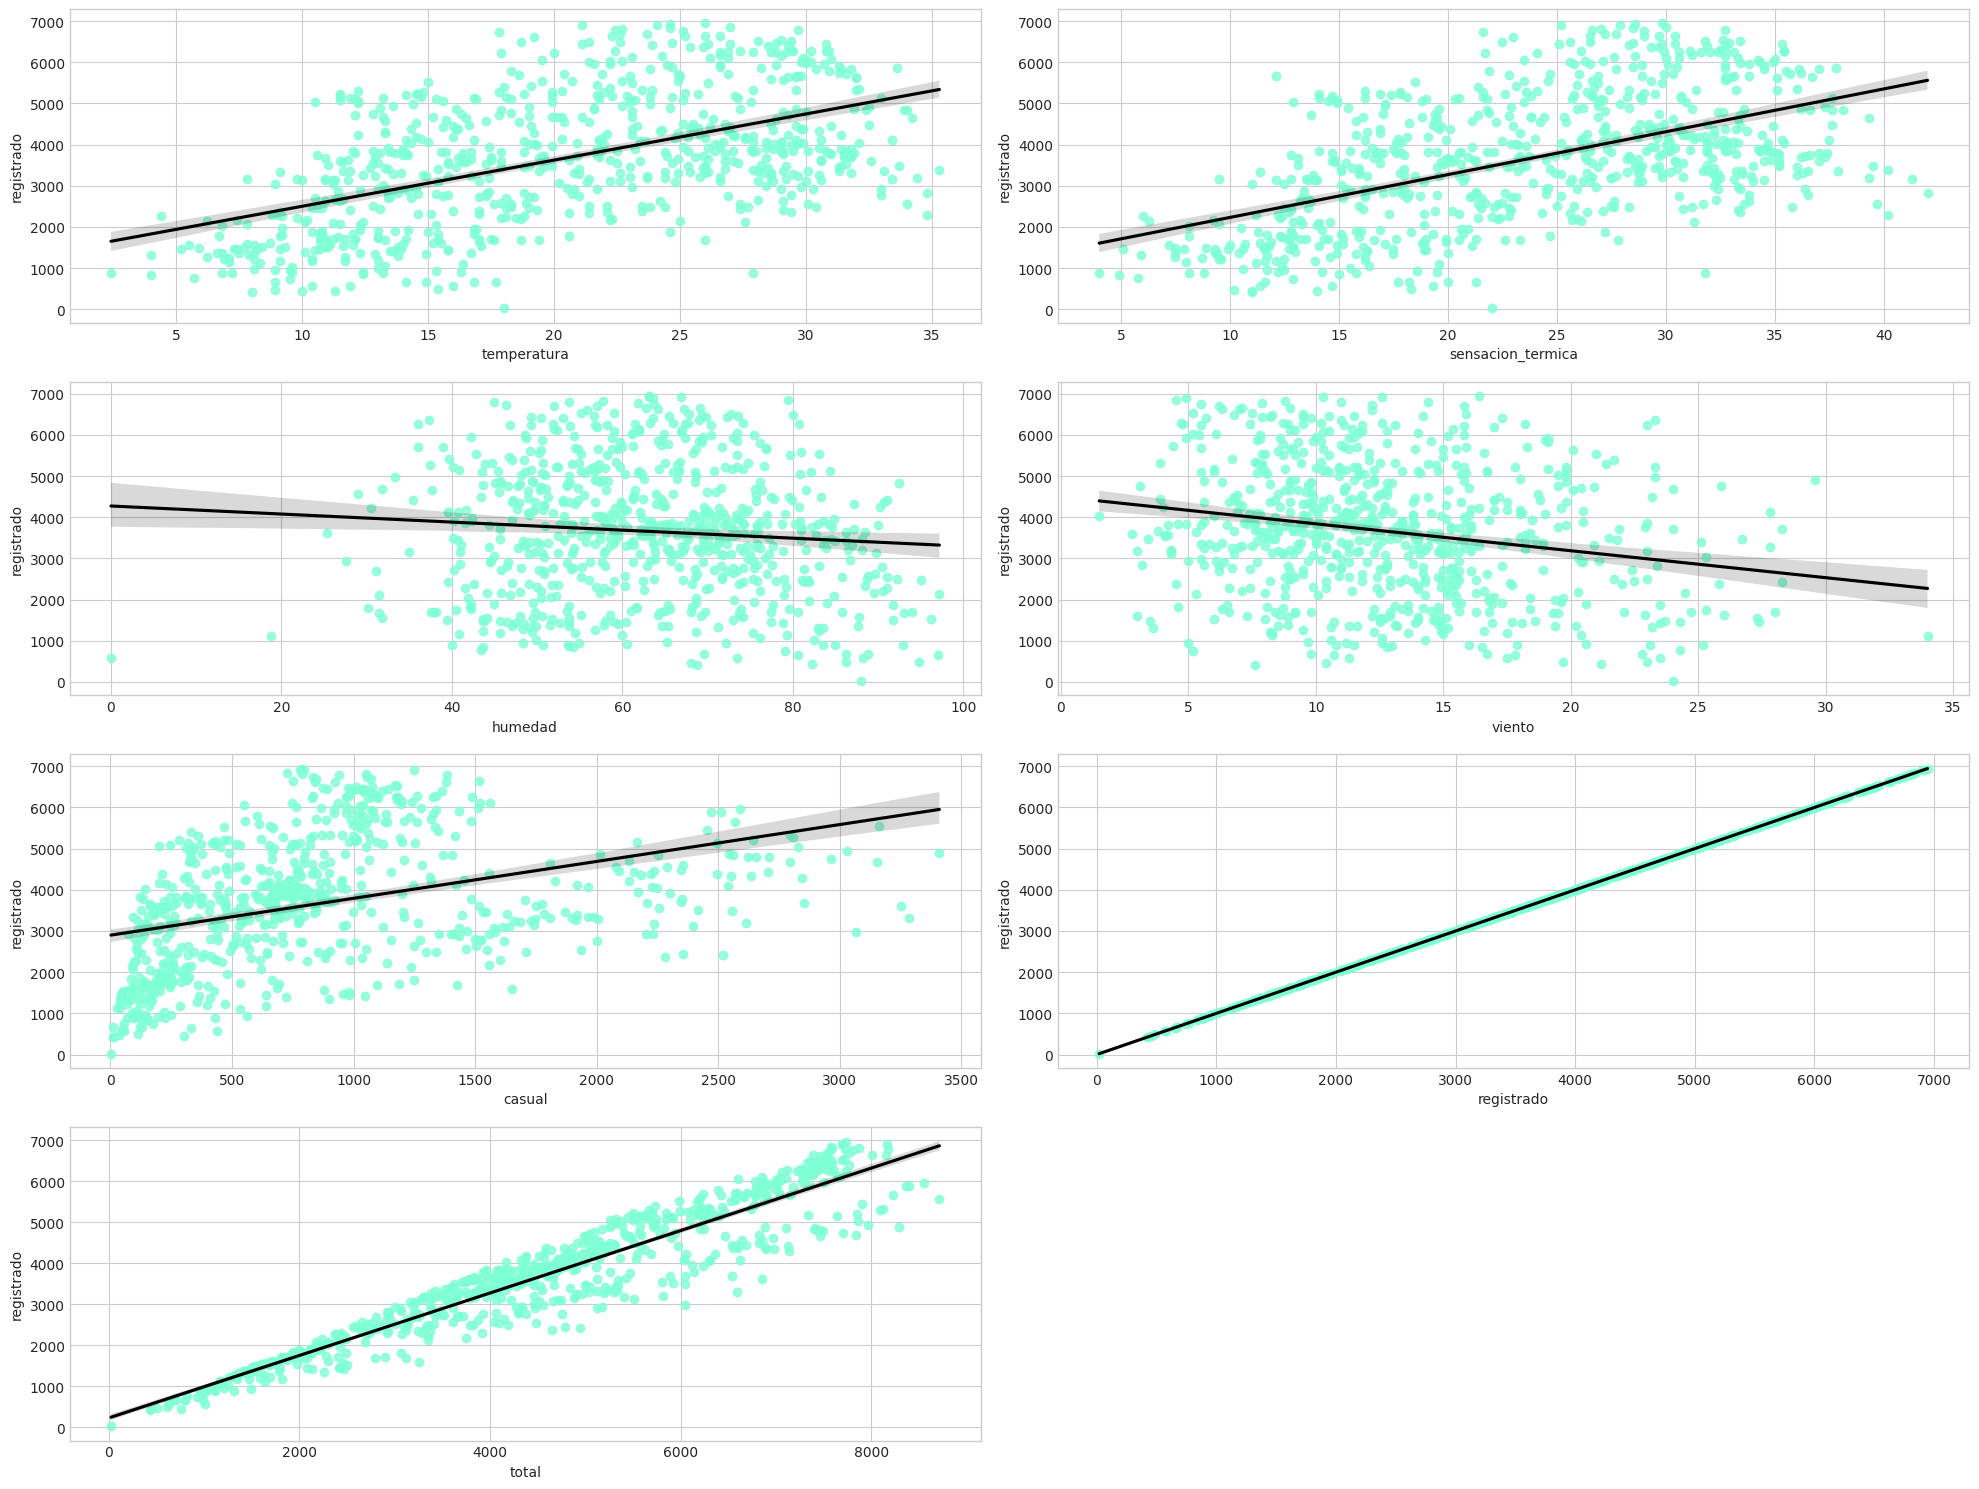

In [6]:
fig, axes = plt.subplots(4, 2, figsize=(20,15))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
        sns.regplot(x = numericas[columna],
                        y = "registrado",
                        data = numericas, ax=axes[indice], 
                        color = "aquamarine", line_kws= {"color": "black"}); 
        
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

In [7]:
sum(df["registrado"]* 100/ df["total"])/ len(df["registrado"]) # Calculamos el porcentaje medio de usuarios totales con los usuarios registados.

82.42104030397692

Como conclusión, tiene sentido el scatterplot que visualizamos más arriba, ya que comprobamos el peso que tienen las variables de usuarios registrados y los usuarios totales que hacen uso del producto.

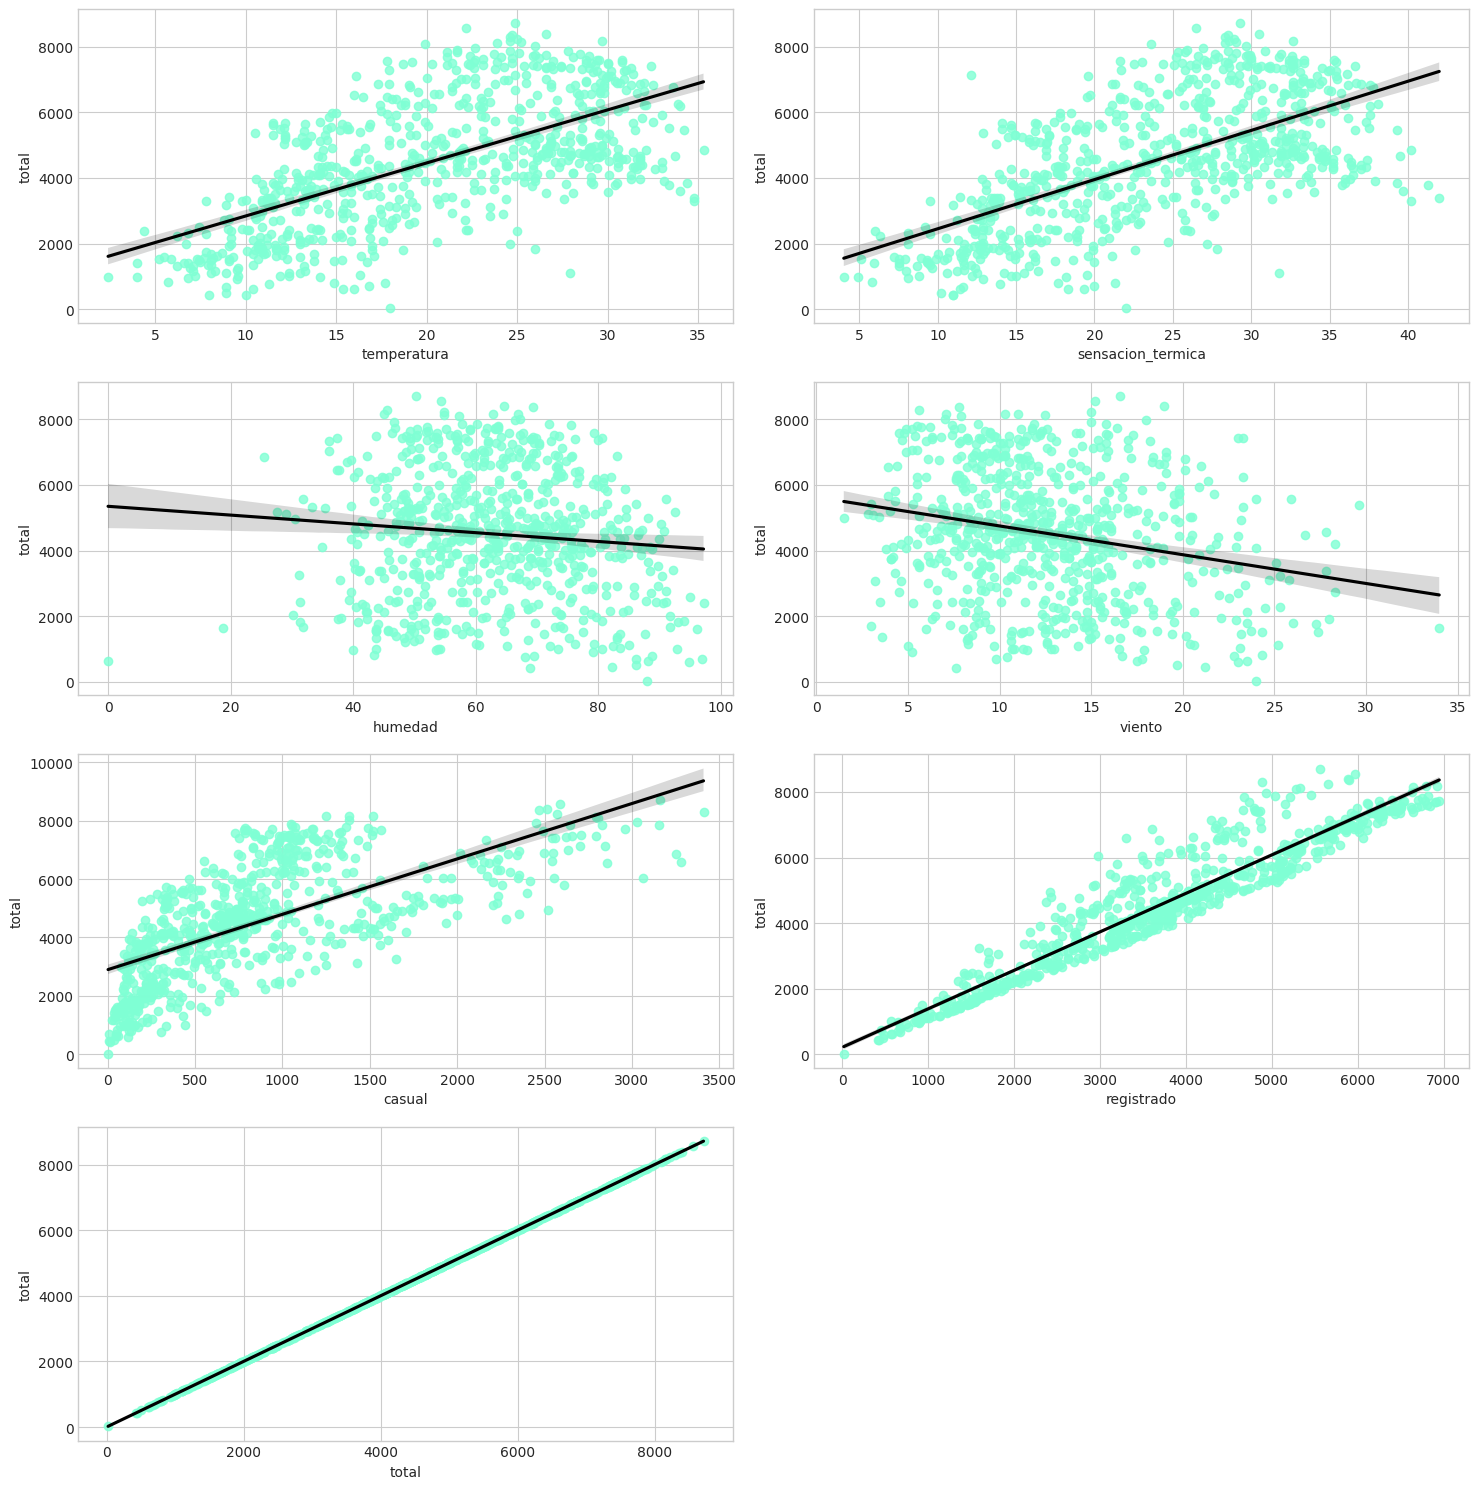

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
        sns.regplot(x = numericas[columna],
                        y = "total",
                        data = numericas, ax=axes[indice], 
                        color = "aquamarine", line_kws= {"color": "black"}); 
        
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()

Como conclusión tiene sentido el scatterplot que visualizamos más arriba ya que 

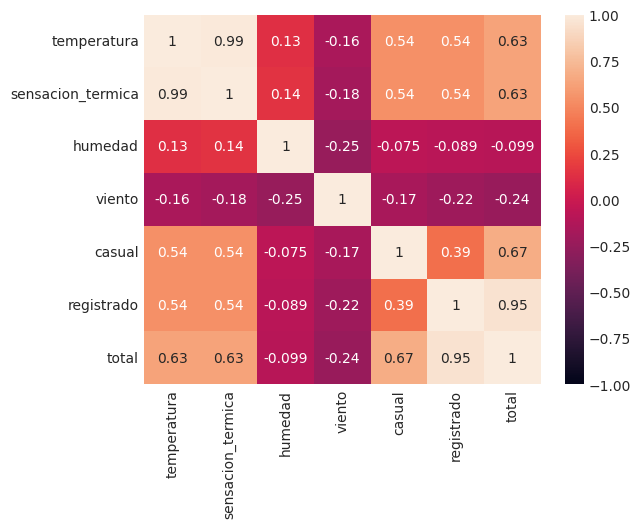

In [9]:
sns.heatmap(numericas.corr(),
            annot = True,
            vmin = -1,
            vmax = 1);


Hay una alta correlación entre temperatura y sensación térmica. 
Además, hay una alta correlación entre los usuarios registrados y los usuarios totales que utilizan las bicicletas, lo cual tiene sentido con el porcentaje que sacamos anteriormente. 

También hay cierta correlación entre la temperatura y el número total de personas que utilizan el servicio, pero el viento y la humedad no afectan de manera significativa, aunque es cierto que hay una correlación negativa.


In [10]:
# Como sensación térmica y temperatura están muy correlacionadas, decidimos eliminar sensación térmica.
df.drop("sensacion_termica", axis = 1, inplace = True)

In [11]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,laboral,clima,temperatura,humedad,viento,casual,registrado,total
0,2018-01-01,invierno,2018,enero,sí,lunes,no,niebla,14.1,80.6,10.7,331,654,985
1,2018-02-01,invierno,2018,febrero,no,jueves,sí,niebla,14.9,69.6,16.7,131,670,801
2,2018-03-01,invierno,2018,marzo,no,jueves,sí,cielo despejado,8.1,43.7,16.6,120,1229,1349
3,2018-04-01,primavera,2018,abril,no,domingo,no,cielo despejado,8.2,59.0,10.7,108,1454,1562
4,2018-05-01,primavera,2018,mayo,no,martes,sí,cielo despejado,9.3,43.7,12.5,82,1518,1600


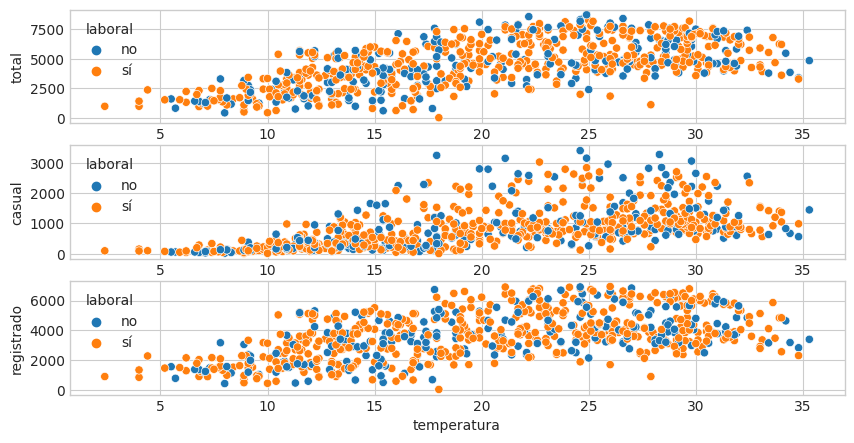

In [12]:
fig, axes = plt.subplots(3, 1, figsize = (10, 5))

sns.scatterplot(x = "temperatura", y = "total", hue = "laboral", data = df, ax = axes[0])
sns.scatterplot(x = "temperatura", y = "casual", hue = "laboral", data = df, ax = axes[1]);
sns.scatterplot(x = "temperatura", y = "registrado", hue = "laboral", data = df, ax = axes[2]);


Como se puede ver en estos scatterplot, entre los usuarios registrados no hay mucha diferencia en cuanto a días laborables y no laborables. Sí parece que no cogen tanto la bicicleta cuando la temperatura es menor. Además, los días de más frío sólo cogen la bicicleta los días que sí son laborables, lo que tiene sentido, ya que quizá lo utilicen como medio de transporte a su lugar de trabajo. 

En cuanto a los usuarios casuales, se puede ver que, en general, la mayor cantidad de usuarios se registran en los días no laborables. En cuanto a temperatura, se puede ver la misma que con los usuarios registrados.

In [13]:
dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]


<Axes: xlabel='dia_semana', ylabel='casual'>

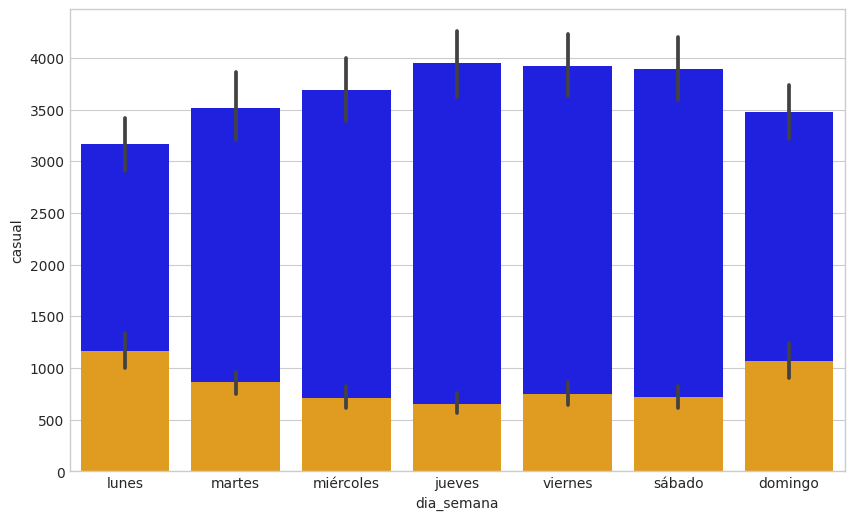

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x="dia_semana", y = "registrado", data = df, label= "Usuarios Registrados", color='blue', order = dias_semana)
sns.barplot(x="dia_semana", y = "casual", data = df, label= "Usuarios Registrados", color='orange', order = dias_semana)

Se puede ver que los usuarios registrados utilizan muchísimo más este servicio. Además, hay una tendencia inversa: cuanto más cogen laa bicicleta los usuarios registrados, menos la cogen los casuales, y viceversa. Destaca que los casuales cogen más la bicicleta los lunes y los domingos. 

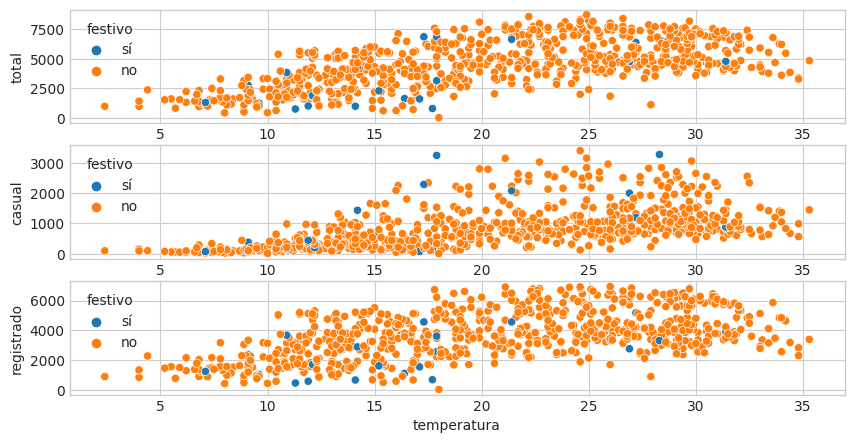

In [15]:
fig, axes = plt.subplots(3, 1, figsize = (10, 5))

sns.scatterplot(x = "temperatura", y = "total", hue = "festivo", data = df, ax = axes[0])
sns.scatterplot(x = "temperatura", y = "casual", hue = "festivo", data = df, ax = axes[1]);
sns.scatterplot(x = "temperatura", y = "registrado", hue = "festivo", data = df, ax = axes[2]);

Los usuarios registrados no cogen tanto la bicicleta en días que son festivos, al contrario que los usuarios casuales. 

In [16]:
df.head()

,fecha,estacion,año,mes,festivo,dia_semana,laboral,clima,temperatura,humedad,viento,casual,registrado,total
0,2018-01-01,invierno,2018,enero,sí,lunes,no,niebla,14.1,80.6,10.7,331,654,985
1,2018-02-01,invierno,2018,febrero,no,jueves,sí,niebla,14.9,69.6,16.7,131,670,801
2,2018-03-01,invierno,2018,marzo,no,jueves,sí,cielo despejado,8.1,43.7,16.6,120,1229,1349
3,2018-04-01,primavera,2018,abril,no,domingo,no,cielo despejado,8.2,59.0,10.7,108,1454,1562
4,2018-05-01,primavera,2018,mayo,no,martes,sí,cielo despejado,9.3,43.7,12.5,82,1518,1600


<Axes: xlabel='mes', ylabel='casual'>

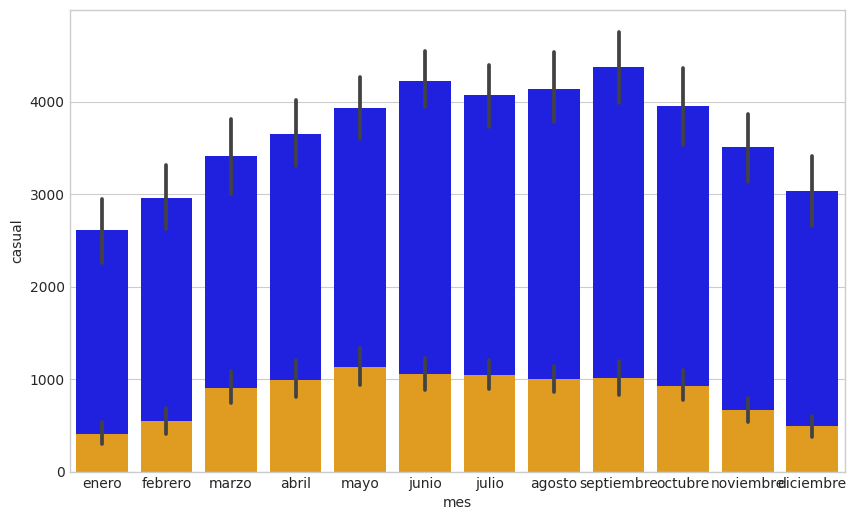

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x="mes", y = "registrado", data = df, label= "Usuarios Registrados", color='blue')
sns.barplot(x="mes", y = "casual", data = df, label= "Usuarios casuales", color='orange')

<Axes: xlabel='año', ylabel='casual'>

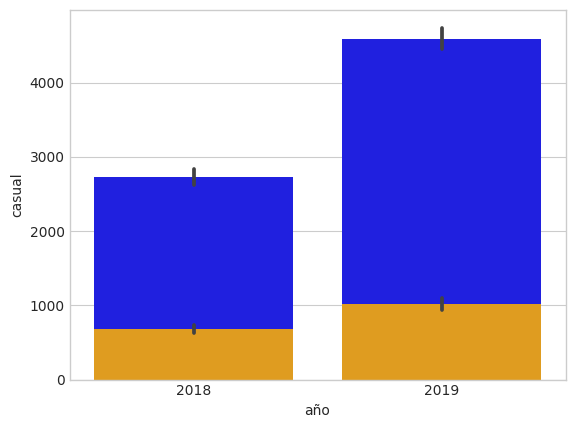

In [18]:
sns.barplot(x="año", y = "registrado", data = df, label= "Usuarios Registrados", color='blue')
sns.barplot(x="año", y = "casual", data = df, label= "Usuarios casuales", color='orange')

En esta gráfica se puede apreciar que los usuarios han crecido muchísimo desde el 2018 al 2019, tanto usuarios registrados como usuaruis casuales. 

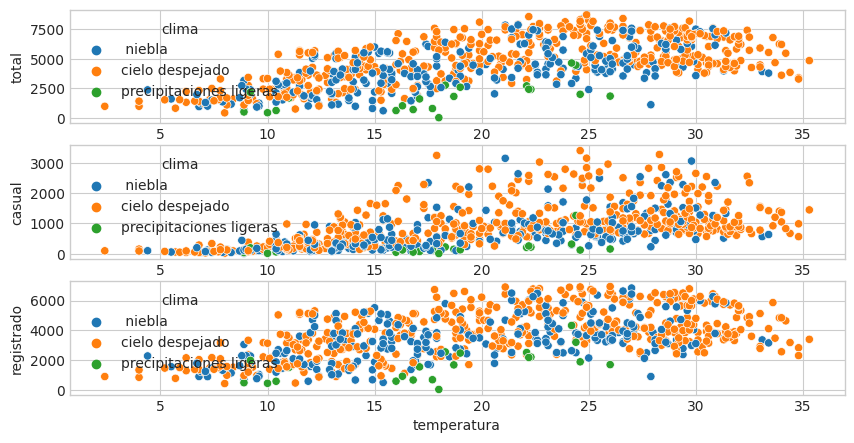

In [19]:
fig, axes = plt.subplots(3, 1, figsize = (10, 5))

sns.scatterplot(x = "temperatura", y = "total", hue = "clima", data = df, ax = axes[0])
sns.scatterplot(x = "temperatura", y = "casual", hue = "clima", data = df, ax = axes[1]);
sns.scatterplot(x = "temperatura", y = "registrado", hue = "clima", data = df, ax = axes[2]);

Se puede apreciar que, por lo general, hay menos usuarios que cogen la bicicleta los días con precipitaciones, y se puede ver que, si hay precipitaciones, sí que influye la temperatura, ya que más gente la coge si hace mejor temperatura, aunque haya precipataciones. Además, en los usuarios registrados no parece afectar tanto los cielos despejados o la niebla, pero en los usuarios casuales sí que hay tendencia a coger más la bicicleta si hay cielo despejado. 